<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/decision_under_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single stage decisions
## Demand side management through ripple control


In [1]:
!git clone https://github.com/nepslor/teaching.git
!pip install pandas==1.5.1


Cloning into 'teaching'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 288 (delta 42), reused 55 (delta 19), pack-reused 201
Receiving objects: 100% (288/288), 61.04 MiB | 8.90 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from teaching.TimeSeriesForecasting.utils.merge_ramps import merge_ramps

data = pd.read_pickle('teaching/TimeSeriesForecasting/data/energy_signature_data.zip')

for k in ['main_p', 'main_q', 'heat_pump_p', 'heat_pump_q']:
  data[k].iloc[:-1], _, _ = merge_ramps(data[k])

data.head()


,GHI,T,battery_p,battery_q,heat_pump_p,heat_pump_q,main_p,main_q,pv_p,pv_q,relay
2015-10-01 00:00:00+00:00,-2.781167,9.500000,0.037667,0.170167,0.0,0.0,0.028167,-0.000333,0.003,0.075833,NaN
2015-10-01 00:01:00+00:00,-2.803333,9.496667,0.038000,0.169333,0.0,0.0,-0.011500,0.001000,0.003,0.075500,NaN
2015-10-01 00:02:00+00:00,-2.856000,9.400000,0.038000,0.170000,0.0,0.0,-0.021833,-0.003833,0.003,0.076000,NaN
2015-10-01 00:03:00+00:00,-2.886833,9.400000,0.038000,0.170000,0.0,0.0,-0.001167,-0.000833,0.003,0.076000,NaN
2015-10-01 00:04:00+00:00,-2.911667,9.400000,0.038000,0.170000,0.0,0.0,0.034500,0.015500,0.003,0.076000,NaN


Before detecting the HP nominal power, derivatives and observations must be at first merged, since sampling introduce dispersion in the distribution of the power jumps, making it difficult to spot accumulation points.


<center>
<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/merging_derivatives.png" width="400", centered=True>
</center>

<font size="-2"><p><center>Example of sampling-induced dispersion. Blue: before merging derivatives. Orange: after merging, clusters are clearly visible</center></p></font>




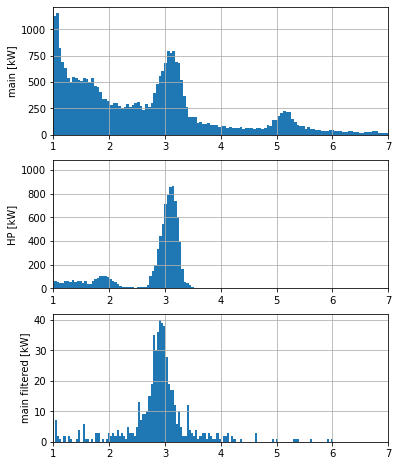

In [11]:

fig, ax= plt.subplots(3, 1, figsize=(6, 8))
n_bins = 200
filt = data['main_p']>1
data['main_p'].loc[filt].\
    hist(bins=n_bins*2, ax=ax[0])

data['heat_pump_p'].loc[filt & data['heat_pump_p']>0].\
    hist(bins=n_bins, ax=ax[1])

data['main_p'].loc[np.roll(data[['relay']].diff().values==1, 1)].loc[filt].\
    hist(bins=n_bins, ax=ax[2])
[a.set_ylabel(t) for a, t in zip(ax, ['main [kW]', 'HP [kW]', 'main filtered [kW]'])]
[a.set_xlim([1, 7]) for a in ax.ravel()];

